In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import heapq
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML

In [2]:
display(HTML('<h1><center>Shortest path for charged constrained Electric Vehicles</center></h1>'))

In [3]:
filename = 'toy_network2.txt'
# filename = 'toy_network.txt'

In [4]:
def read_graph_from_file(filename):
    graph_df = pd.read_csv(filename, sep=" ", header=None, names=['Source', 'Target', 'Weight'])
    return graph_df

In [5]:
def build_graph_from_df(graph_df):
    G = nx.Graph()
    for _, row in graph_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])
    return G

In [6]:
graph_df = read_graph_from_file(filename)
G = build_graph_from_df(graph_df)
charger_nodes = [2,4,9,17]
quick_charger_nodes = [7,13]
pos_seed = 112
current_figure = None

In [7]:
graph_df

,Source,Target,Weight
0,0,1,60
1,0,4,80
2,0,17,120
3,1,2,70
4,1,3,40
5,1,18,130
6,2,6,30
7,2,11,20
8,3,4,130
9,3,6,30


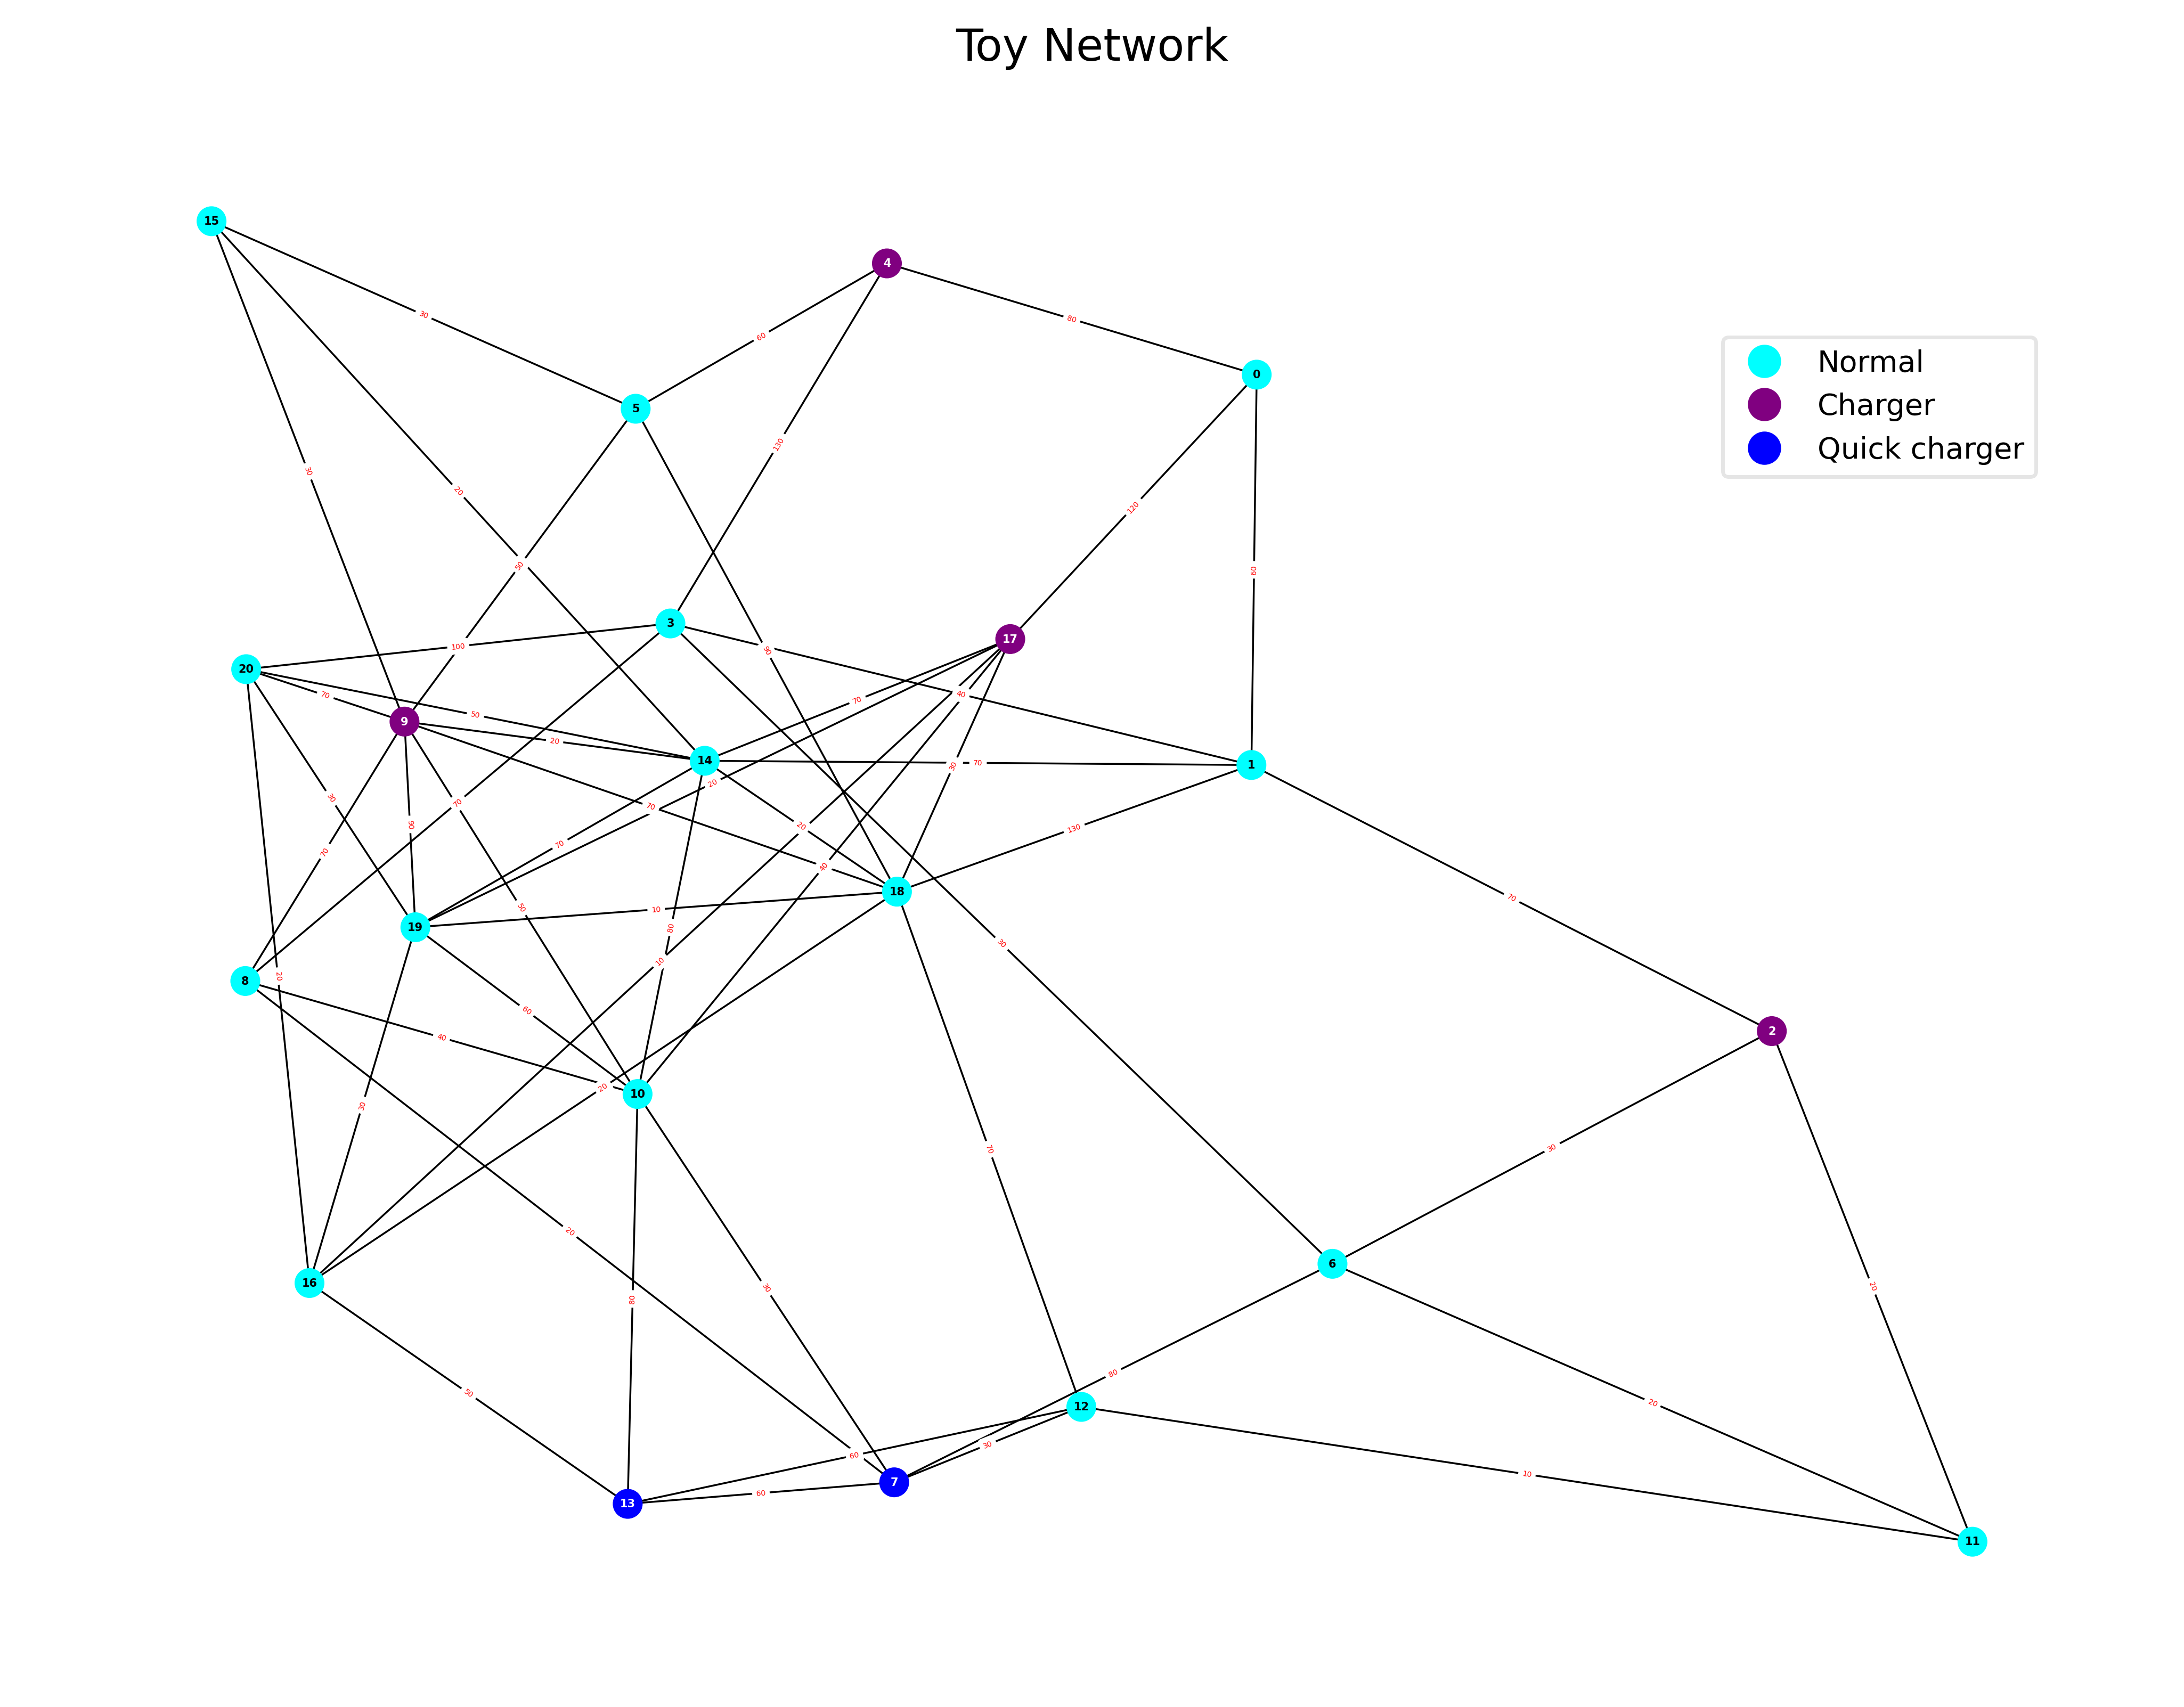

In [8]:
figure = plt.figure(figsize=(8,6),
                    dpi = 500)
node_colors = []
font_colors = []
for node in G.nodes():
    if node in charger_nodes:
        node_colors.append('purple')
        font_colors.append('white')
    elif node in quick_charger_nodes:
        node_colors.append('blue')
        font_colors.append('white')
    else:
        node_colors.append('cyan')
        font_colors.append('black')

pos = nx.spring_layout(G, seed=pos_seed)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G,
        pos,
        with_labels = False,
        # font_weight = 'bold',
        node_size = 50,
        node_color = node_colors,
        # font_size = 3,
        # font_color = font_colors,
        width = 0.5)

for node, font_color in zip(G.nodes(), font_colors):
    nx.draw_networkx_labels(G,
                            pos, 
                            labels={node: node}, 
                            font_color=font_color, 
                            font_size=3, 
                            font_weight='bold')

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels,
                             font_color='red',
                             font_size=2)

legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='cyan', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Charger', markerfacecolor='purple', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Quick charger', markerfacecolor='blue', markersize=10)
    ]
legend = plt.legend(handles=legend_elements, loc='upper right', fontsize=8, bbox_to_anchor=(0.95, 0.85))
legend.get_frame().set_alpha(0.5)
plt.title("Toy Network")

plt.show()

In [9]:
def dijkstra_mod(graph, start, charger_nodes, quick_charger_nodes, threshold, charging_penalty, quick_charging_penalty, refill_threshold):
    node_attr = {
        node: {
            "penalty_dist": float('infinity'),
            "non_charged_dist": float('infinity'),
            "charged_dist": float('infinity'),
            "previous_node": None
        }
        for node in graph
    }

    # Initialize start node distances
    node_attr[start]["non_charged_dist"] = 0
    node_attr[start]["charged_dist"] = 0
    node_attr[start]["penalty_dist"] = 0

    # Priority queue holds tuples of (penalty distance, non-charged distance, charged distance, node)
    priority_queue = [(0, 0, 0, start)]  # (penalty_dist, non_charged_dist, charged_dist, node)
    
    while priority_queue:
        # Pop the node with the smallest penalty distance
        total_distance, total_dist_wo_penalty, current_distance, current_node = heapq.heappop(priority_queue)

        # Skip processing if the popped node's penalty distance is greater than the already found best distance
        if total_distance > node_attr[current_node]["penalty_dist"]:
            continue

        # Handle charging at charger nodes
        if current_distance >= refill_threshold:
            if current_node in charger_nodes:
                total_distance = total_distance + np.floor(charging_penalty * current_distance/threshold)
                current_distance = 0  # Reset the charged distance
            
            if current_node in quick_charger_nodes:
                total_distance = total_distance + np.floor(quick_charging_penalty * current_distance/threshold)
                current_distance = 0  # Reset the charged distance
        
        for neighbor in graph.neighbors(current_node):
            weight = graph[current_node][neighbor]['weight']
            charged_distance = current_distance + weight
            non_charged_distance = total_dist_wo_penalty + weight
            penalty_distance = total_distance + weight

            # Skip the neighbor if the charged distance exceeds the threshold
            if charged_distance > threshold:
                continue

            # Update neighbor distances if a better path is found
            if penalty_distance < node_attr[neighbor]["penalty_dist"]:
                node_attr[neighbor]["non_charged_dist"] = non_charged_distance
                node_attr[neighbor]["penalty_dist"] = penalty_distance
                node_attr[neighbor]["charged_dist"] = charged_distance
                node_attr[neighbor]["previous_node"] = current_node
                heapq.heappush(priority_queue, (penalty_distance, non_charged_distance, charged_distance, neighbor))
    
    for node, attr in node_attr.items():
        if attr["charged_dist"] == attr["non_charged_dist"]:
            attr["penalty_dist"] = attr["charged_dist"]
        elif attr["non_charged_dist"] <= threshold:
            attr["penalty_dist"] = attr["non_charged_dist"]

    return node_attr

In [10]:
def reconstruct_path(node_attr, start, target):
    path = []
    current_node = target
    while current_node is not None:
        path.append(current_node)
        current_node = node_attr[current_node]["previous_node"]
    path.reverse()
    return path if path[0] == start else None

In [11]:
def visualize_graph(graph_df, node_attr, charger_nodes, quick_charger_nodes, start_node, target_node, threshold, path_edges):
    G = nx.Graph()
    # figure = plt.figure(figsize=(8, 6), dpi=500)
    
    global current_figure
    if current_figure is not None:
        plt.close(current_figure)  # Close the previous figure

    current_figure = plt.figure(figsize=(8, 6), dpi=500)  # Create a new figure

    plt.clf()
    # Add edges to the graph
    for _, row in graph_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

    # Initialize node colors, sizes, and font color groups
    node_colors = []
    node_sizes = []
    black_font_nodes = []
    white_font_nodes = []
    
    for node in G.nodes():
        if node == start_node:
            node_colors.append('green')
            node_sizes.append(100)
            black_font_nodes.append(node)
        elif node == target_node:
            node_colors.append('yellow')
            node_sizes.append(100)
            black_font_nodes.append(node)
        elif node in charger_nodes:
            node_colors.append('purple')
            node_sizes.append(180)
            white_font_nodes.append(node)
        elif node in quick_charger_nodes:
            node_colors.append('blue')
            node_sizes.append(200)
            white_font_nodes.append(node)
        else:
            node_colors.append('cyan')
            node_sizes.append(50)
            black_font_nodes.append(node)

    # Define edge labels
    edge_labels = {(row['Source'], row['Target']): row['Weight'] for _, row in graph_df.iterrows()}

    # Define node labels
    node_labels = {node: f"{node}\n({node_attr[node]['non_charged_dist']})" for node in G.nodes()}
    
    # Set edge colors and widths based on path_edges
    edge_colors = ['red' if (edge in path_edges) or (edge[::-1] in path_edges) else 'gray' for edge in G.edges()]
    edge_widths = [2 if (edge in path_edges) or (edge[::-1] in path_edges) else 0.5 for edge in G.edges()]

    # Get positions for the nodes
    pos = nx.spring_layout(G, seed=pos_seed)

    # Draw the graph with custom node sizes
    nx.draw(G, 
            pos, 
            with_labels=False, 
            node_color=node_colors, 
            node_size=node_sizes, 
            edge_color=edge_colors, 
            width=edge_widths)

    # Draw node labels with black font color
    nx.draw_networkx_labels(G, pos, labels={node: node_labels[node] for node in black_font_nodes},
                            font_color='black', font_size=3, font_weight='bold')

    # Draw node labels with white font color
    nx.draw_networkx_labels(G, pos, labels={node: node_labels[node] for node in white_font_nodes},
                            font_color='white', font_size=3, font_weight='bold')

    # Split the edge labels into two sets: one for path edges and another for non-path edges
    path_edge_labels = {}
    for edge in path_edges:
        # Check if the edge or its reverse exists in edge_labels and add it to path_edge_labels
        label = edge_labels.get(edge) or edge_labels.get(edge[::-1])
        if label is not None:
            path_edge_labels[edge] = label

    non_path_edge_labels = {}
    for edge in G.edges():
        if edge not in path_edge_labels and edge[::-1] not in path_edge_labels:
            non_path_edge_labels[edge] = edge_labels.get(edge) or edge_labels.get(edge[::-1])

    # Draw edge labels for path edges with specified font size and color
    nx.draw_networkx_edge_labels(G, pos, edge_labels=path_edge_labels, font_color='darkblue', font_size=4, font_weight='bold')

    # Draw edge labels for non-path edges with default font size and color
    nx.draw_networkx_edge_labels(G, pos, edge_labels=non_path_edge_labels, font_color='red', font_size=3)

    # Set the title and display the plot
    plt.title(f"Shortest Path to Node {target_node} Highlighted and Threshold {threshold}")
    
    shortest_dist = node_attr[target_node]["non_charged_dist"]
    penalty_dist = node_attr[target_node]["penalty_dist"]
    
    plt.text(0.95, 0.95, 
             f"Shortest distance covered: {shortest_dist}\n"
             f"Distance that could've been covered instead of charging: {penalty_dist}",
             transform=plt.gca().transAxes, 
             fontsize=8, 
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='cyan', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Start', markerfacecolor='green', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Target', markerfacecolor='yellow', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Charger', markerfacecolor='purple', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Quick charger', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], color='red', lw=2, label='Shortest path')
    ]
    legend = plt.legend(handles=legend_elements, loc='upper right', fontsize=8, bbox_to_anchor=(0.95, 0.85))
    legend.get_frame().set_alpha(0.5)
    
    # plt.tight_layout()
    plt.show()

In [12]:
start_node = 0
threshold = 120
charging_penalty = 80
quick_charging_penalty = 30
refill_threshold_percent = 0.5
refill_threshold = np.floor(threshold * refill_threshold_percent).astype(int)
charger_nodes = [2,4,9,17]
quick_charger_nodes = [7,13]

In [13]:
node_attr = dijkstra_mod(G, start_node, charger_nodes, quick_charger_nodes, threshold, charging_penalty, quick_charging_penalty, refill_threshold)

In [14]:
df = pd.DataFrame([
        {
            "Node": node,
            "Post-penalty Dist": attr["penalty_dist"],
            "Distance": attr["non_charged_dist"],
            "Path": None
        }
        for node, attr in node_attr.items()
    ])

df.set_index('Node', inplace=True)
df.sort_index(inplace=True)


In [15]:
display(HTML('<h3>Table of shortest paths</h3>'))

In [16]:
df["Path"] = None
for node in G.nodes():
    if node != start_node:
        path = reconstruct_path(node_attr, start_node, node)
        df.at[node, "Path"] = path
df

,Post-penalty Dist,Distance,Path
Node,,,
0,0.0,0,None
1,60.0,60,"[0, 1]"
2,397.0,300,"[0, 17, 10, 7, 6, 2]"
3,100.0,100,"[0, 1, 3]"
4,80.0,80,"[0, 4]"
5,193.0,140,"[0, 4, 5]"
6,367.0,270,"[0, 17, 10, 7, 6]"
7,270.0,190,"[0, 17, 10, 7]"
8,280.0,200,"[0, 17, 10, 8]"


In [17]:
display(HTML('<h3>Interactive Dashboard</h3>'))

[0, 17, 18, 12, 11]


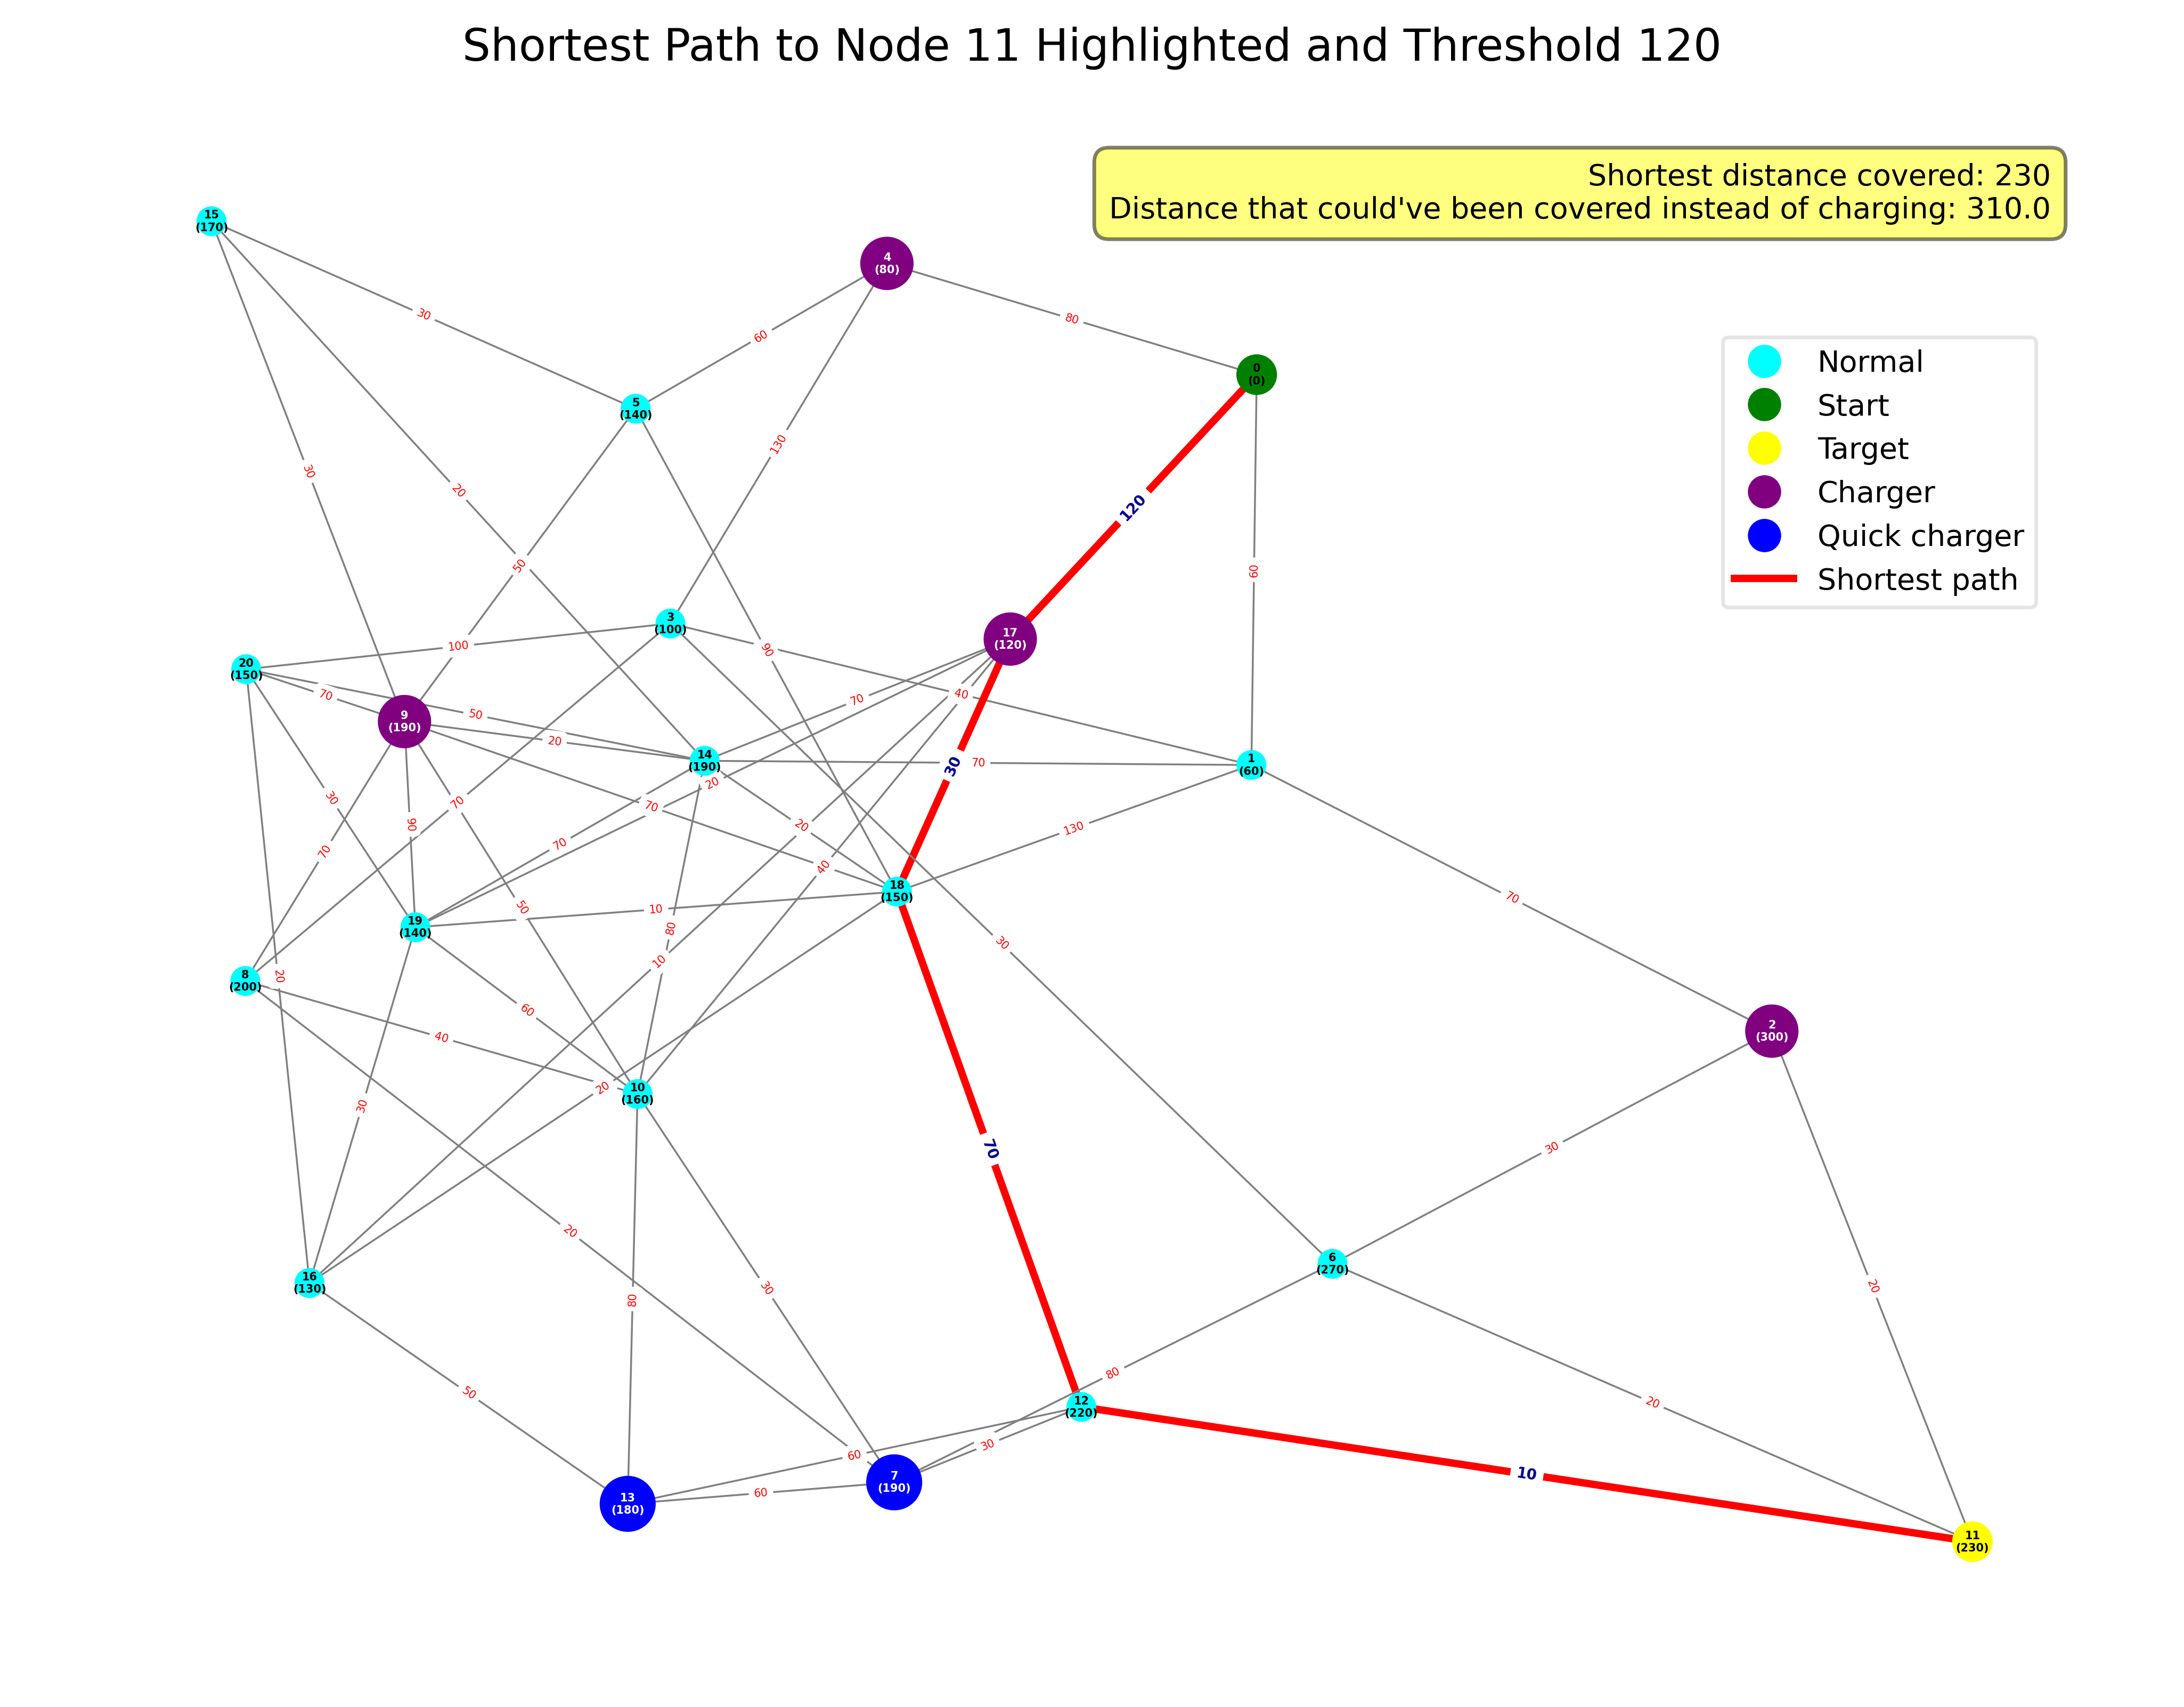

In [18]:
target_node = 11
path = reconstruct_path(node_attr, start_node, target_node)
print(path)
if path:
    # Highlight the shortest path on the graph
    path_edges = list(zip(path, path[1:]))  # Create pairs of nodes for edges
    visualize_graph(graph_df, node_attr, charger_nodes, quick_charger_nodes, start_node, target_node, threshold, path_edges)

In [19]:
def interactive_visualization(graph_df, G, charger_nodes, quick_charger_nodes, start_node, charging_penalty, quick_charging_penalty):
    possible_target_nodes = list(graph_df['Target'].unique()) + list(graph_df['Source'].unique())
    possible_target_nodes = sorted(set(possible_target_nodes))
 
    target_node_dropdown = widgets.Dropdown(
        options=possible_target_nodes,
        description='Target Node:',
        value=1,
        style={'description_width': 'initial'}
    )
 
    threshold_slider = widgets.IntSlider(
        value=120,
        min=100,
        max=200,
        step=1,
        description='Threshold:',
        style={'description_width': 'initial'}
    )
 
    refill_threshold_percent_slider = widgets.FloatSlider(
        value=0.5,
        min=0.2,
        max=1.0,
        step=0.01,
        description='Refill Threshold %:',
        style={'description_width': 'initial'}
    )
 
    output = widgets.Output()
 
    def update_visualization(change):
        target_node = target_node_dropdown.value
        threshold = threshold_slider.value
        refill_threshold_percent = refill_threshold_percent_slider.value
        refill_threshold = np.floor(threshold * refill_threshold_percent).astype(int)
 
        node_attr = dijkstra_mod(G, start_node, charger_nodes, quick_charger_nodes, threshold, charging_penalty, quick_charging_penalty, refill_threshold)
        path = reconstruct_path(node_attr, start_node, target_node)
 
        with output:
            clear_output(wait=True)
            print(f"Path to {target_node}: {path}")
            print(f"Threshold: {threshold}")
            print(f"Refill Threshold %: {refill_threshold_percent:.2f}")
            print(f"Refill Threshold: {refill_threshold}")
 
            if path:
                path_edges = list(zip(path, path[1:]))
                visualize_graph(graph_df, node_attr, charger_nodes, quick_charger_nodes, start_node, target_node, threshold, path_edges)
 
    target_node_dropdown.observe(update_visualization, names='value')
    threshold_slider.observe(update_visualization, names='value')
    refill_threshold_percent_slider.observe(update_visualization, names='value')
 
    display(widgets.VBox([target_node_dropdown, threshold_slider, refill_threshold_percent_slider, output]))
 
    # Initial visualization
    update_visualization({'new': target_node_dropdown.value})

In [20]:
interactive_visualization(graph_df, G, charger_nodes, quick_charger_nodes, start_node, charging_penalty, quick_charging_penalty)